In [9]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import uncertainties as unc

In [10]:
def transfer(F, Cap, R):
    CIn = unc.ufloat(25e-12,1e-12)
    C = (Cap)*(CIn)/(Cap + CIn)
    Rin = unc.ufloat(10e6, 1e6)
    omega = 2*np.pi*F
    return 1/((R/Rin+1)**2+(omega*C*R)**2)**0.5

def curveFit(f, a, b, c,d, e):
    return np.sqrt(a**2+(b*f**-0.5)**2 + (c*np.exp(-((f-d)**2)/e))**2)

def readData(fileName: str):
    data = pd.read_csv(fileName, sep="\t", header=None)
    return data[0], data[1]
def expected(R, T):
    return (4*1.380649e-23*T*R)**0.5

def expectedSlope(c,d,T):
    return (4*1.380649e-23*T/(2*np.pi*c))**0.5



0.06405111704962811 0.14300066995941668 0.20380011074927695


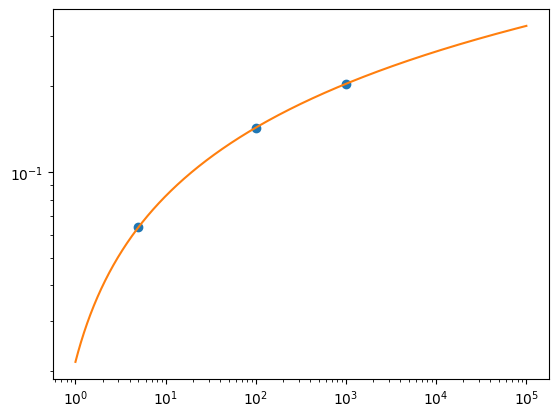

In [11]:
_, uncsV = readData("uncs.txt")
five = uncsV[0:20]
hundred = uncsV[20:40]
thousand = uncsV[40:60]
uncPctFive = np.std(five)/np.mean(five)
uncPctHundred = np.std(hundred)/np.mean(hundred)
uncPctThousand = np.std(thousand)/np.mean(thousand)
print(uncPctFive, uncPctHundred, uncPctThousand)
def uncFit(f, m, b):
    return m*np.log10(f)+b

uncpopt, pcov = curve_fit(uncFit, [5, 100, 1000], [uncPctFive, uncPctHundred, uncPctThousand] )
plt.plot([5, 100, 1000], [uncPctFive, uncPctHundred, uncPctThousand], 'o')
plt.plot(np.logspace(0, 5, num=1000), uncFit(np.logspace(0,5, num=1000), *uncpopt))
plt.xscale("log")
plt.yscale("log")
plt.show()
def voltageUncertainty(f):
    return uncFit(f, *uncpopt)

(1.1+/-0.4)e+08
[1.32337768e-06 2.79529528e-05 2.17513071e-05 7.95458263e+01
 6.80244938e+02] [[ 4.05757224e-14 -1.62352223e-13 -8.71067837e-15 -9.76665443e-09
   5.88433560e-07]
 [-1.62352223e-13  1.54803642e-11  1.06145369e-12  1.17900246e-06
  -1.38872318e-04]
 [-8.71067837e-15  1.06145369e-12  7.71320239e-11  4.88112471e-06
  -2.07047531e-03]
 [-9.76665443e-09  1.17900246e-06  4.88112471e-06  1.64626000e+01
  -2.11843539e+02]
 [ 5.88433560e-07 -1.38872318e-04 -2.07047531e-03 -2.11843539e+02
   9.33868339e+04]]
1.1401017512407638


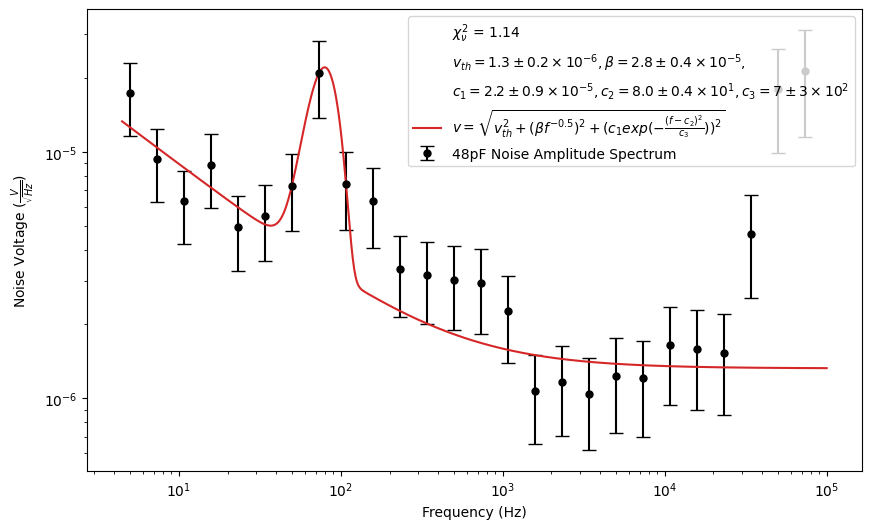

<Figure size 640x480 with 0 Axes>

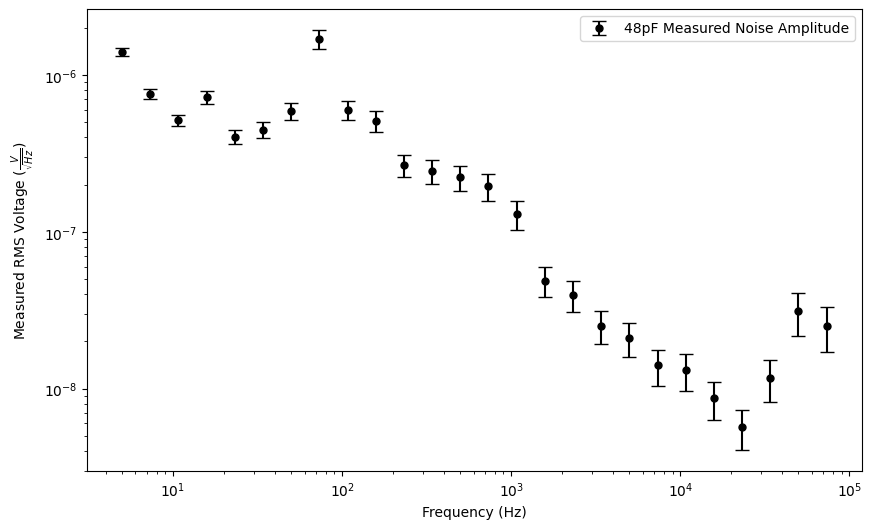

(8.8+/-2.9)e+07
[1.01852693e-06 2.18581284e-05 1.24073430e-05 8.53417134e+01
 7.57985401e+02] [[ 2.17299964e-14 -1.04853583e-13 -1.06844483e-14 -1.36966955e-08
   1.89953806e-06]
 [-1.04853583e-13  8.37809550e-12  1.32718528e-12  1.71213129e-06
  -2.84607216e-04]
 [-1.06844483e-14  1.32718528e-12  2.71503244e-11  4.91135548e-07
  -2.08092696e-03]
 [-1.36966955e-08  1.71213129e-06  4.91135548e-07  2.60594358e+01
  -2.12060305e+02]
 [ 1.89953806e-06 -2.84607216e-04 -2.08092696e-03 -2.12060305e+02
   2.59907267e+05]]
1.016293248351529


<Figure size 640x480 with 0 Axes>

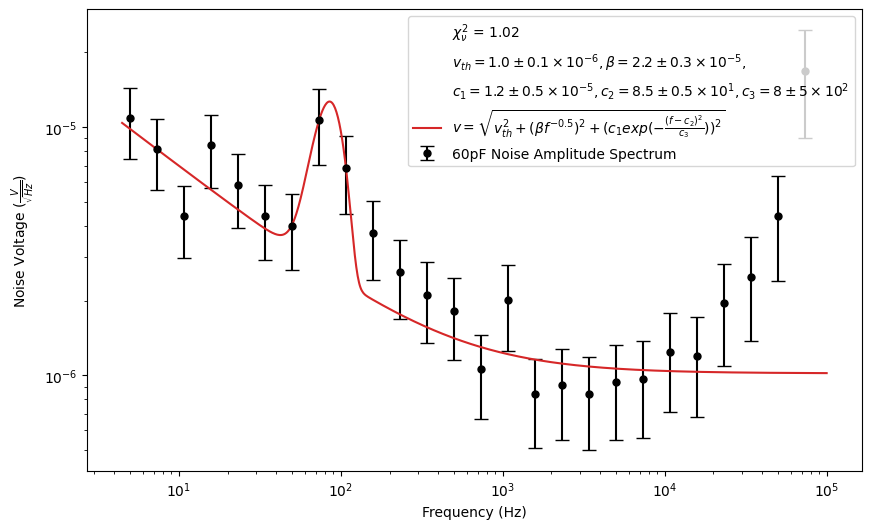

<Figure size 640x480 with 0 Axes>

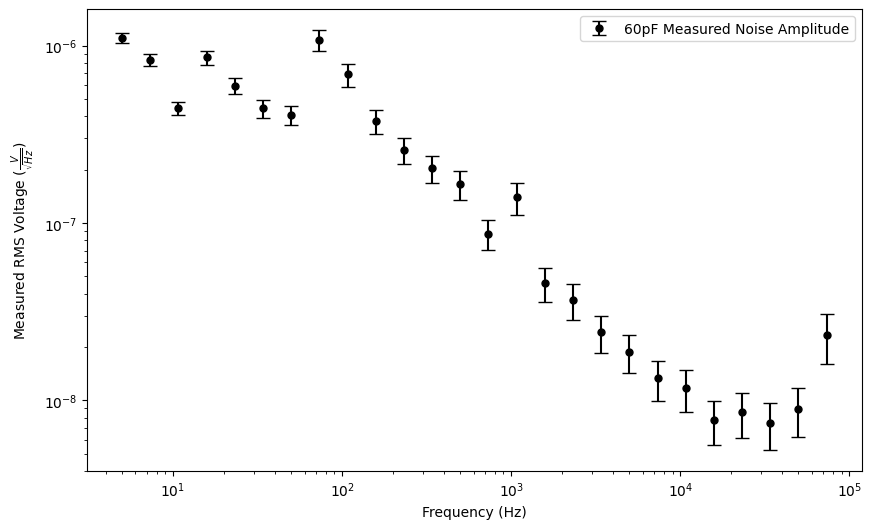

(7.2+/-2.4)e+07
[6.46387049e-07 1.99302923e-05 4.10796078e-05 7.80769391e+01
 3.83742889e+02] [[ 1.46502837e-14 -9.16185953e-14 -3.98057619e-15 -2.31262715e-09
   1.49157012e-07]
 [-9.16185953e-14  6.33198331e-12  2.74955246e-13  1.29377312e-07
  -1.53689564e-05]
 [-3.98057619e-15  2.74955246e-13  2.33330995e-10  6.79157049e-06
  -1.03865311e-03]
 [-2.31262715e-09  1.29377312e-07  6.79157049e-06  4.58205477e+00
  -4.24247933e+01]
 [ 1.49157012e-07 -1.53689564e-05 -1.03865311e-03 -4.24247933e+01
   7.80171453e+03]]
1.117653765766359


<Figure size 640x480 with 0 Axes>

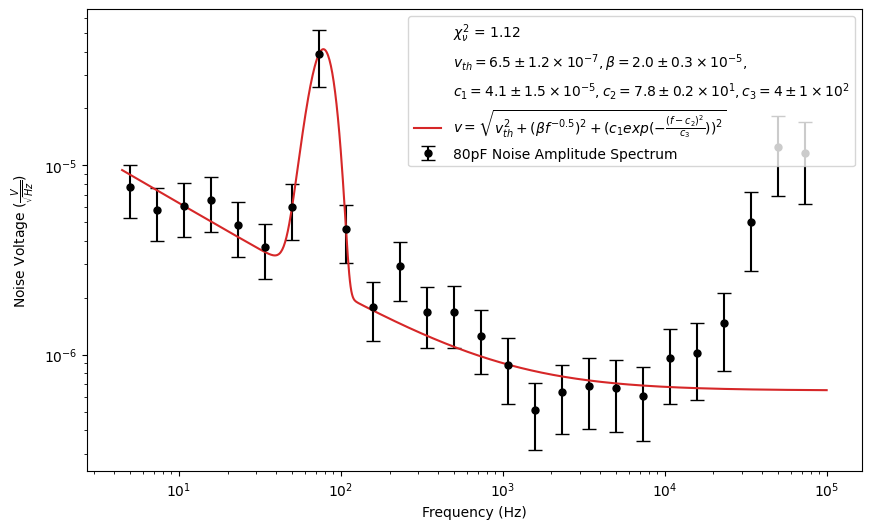

<Figure size 640x480 with 0 Axes>

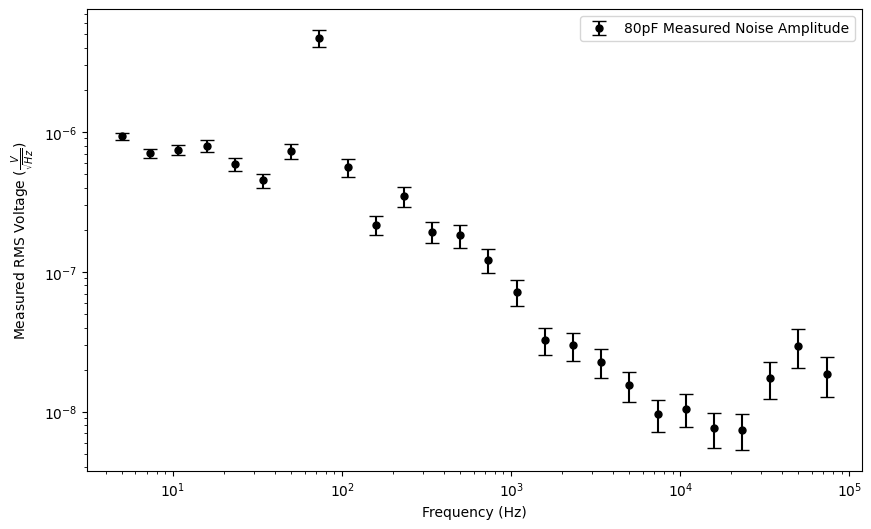

<Figure size 640x480 with 0 Axes>

In [12]:
capacitances = [unc.ufloat(47.1, 0.1)*1e-12, unc.ufloat(60.0, 0.1)*1e-12, unc.ufloat(73.6, 0.01)*1e-12]
ds = [unc.ufloat(0.003, 0.001), unc.ufloat(0.003, 0.001), unc.ufloat(0.003, 0.001)]
data = glob.glob("capData/*.txt")
T = unc.ufloat(273.3 + 22.9, 0.1)
datalabels = [r"48pF", r"60pF", r"80pF"]
for file, cap, d, label in zip(data, capacitances, ds, datalabels):
    f, V = readData(file)
    R = 1/(2*np.pi*1e4*cap*d)
    print(R)
    vsWithUnc = [unc.ufloat(v, v*voltageUncertainty(F))/transfer(F, cap, R) for v, F in zip(V, f)]
    vsNoUnc = [v.n for v in vsWithUnc]
    vsUnc = [v.s for v in vsWithUnc]
    maxFreq = f[np.argmax(vsNoUnc[5:15])+5]+5
    popt, pcov = curve_fit(curveFit, f, vsNoUnc, p0=[expected(R, T).n, 1e-5, 1e-5, maxFreq, 100], sigma=vsUnc, bounds=(0, np.inf))
    print(popt, pcov)
    expectedVals = np.ones_like(f)*expected(R, T).n
    fs = np.logspace(0.65, 5, num=1000)
    fitName = r"$v = \sqrt{v_{th}^2 + (\beta f^{-0.5})^2 + (c_1 exp(-\frac{(f-c_2)^2}{c_3}))^2}$"
    vthExponent = np.floor(np.log10(popt[0]))
    vthVal = popt[0]/10**vthExponent
    vthErr = np.sqrt(pcov[0,0])/10**vthExponent
    betaExponent = np.floor(np.log10(popt[1]))
    betaVal = popt[1]/10**betaExponent
    betaErr = np.sqrt(pcov[1,1])/10**betaExponent
    c1Exponent = np.floor(np.log10(popt[2]))
    c1Val = popt[2]/10**c1Exponent
    c1Err = np.sqrt(pcov[2,2])/10**c1Exponent
    c2Exponent = np.floor(np.log10(popt[3]))
    c2Val = popt[3]/10**c2Exponent
    c2Err = np.sqrt(pcov[3,3])/10**c2Exponent
    c3Exponent = np.floor(np.log10(popt[4]))
    c3Val = popt[4]/10**c3Exponent
    c3Err = np.sqrt(pcov[4,4])/10**c3Exponent
    chi2 = np.sum(np.pow(np.array(vsNoUnc)-curveFit(f, *popt), 2)/np.array(vsUnc)**2)/(len(vsNoUnc)-5)
    fitVals = rf"$v_{{th}} = {vthVal:.1f} \pm {vthErr:.1f} \times 10^{{{vthExponent:.0f}}}, \beta = {betaVal:.1f} \pm {betaErr:.1f} \times 10^{{{betaExponent:.0f}}},$"
    fitValspt2 = rf"$c_1 = {c1Val:.1f} \pm {c1Err:.1f} \times 10^{{{c1Exponent:.0f}}}, c_2 = {c2Val:.1f} \pm {c2Err:.1f} \times 10^{{{c2Exponent:.0f}}}, c_3 = {c3Val:.0f} \pm {c3Err:.0f} \times 10^{{{c3Exponent:.0f}}}$"
    plt.figure(figsize=(10, 6))
    plt.plot([], [], ' ', label=rf"$\chi^2_\nu$ = {chi2:.2f}")
    plt.plot([], [], ' ', label=fitVals)
    plt.plot([], [], ' ', label=fitValspt2)
    plt.errorbar(f, vsNoUnc, yerr=vsUnc, label=label + " Noise Amplitude Spectrum", fmt="ko", capsize=5, markersize=5)
    plt.plot(fs, curveFit(fs, *popt), label=fitName)
    
    print(chi2)
    # plt.plot(f, expect, label="Expected for " + file)
    # print("Expected: ", expectedSlope(cap, d, T))
    # print("Fit: ", popt, pcov)
    
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel(r"Noise Voltage $(\frac{V}{\sqrt{Hz}})$")
    plt.legend()
    plt.savefig(f"plots/{label}.svg", bbox_inches="tight")
    plt.show()
    plt.clf()
    plt.figure(figsize=(10, 6))
    expectedMeasurement = [(expected(R, T)*transfer(F, cap, R)).n for F in fs]
    plt.errorbar(f, V, yerr=V*voltageUncertainty(f), label=label + " Measured Noise Amplitude", fmt="ko", capsize=5, markersize=5)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel(r"Measured RMS Voltage ($\frac{V}{\sqrt{Hz}}$)")
    plt.legend()
    plt.savefig(f"plots/{label}Measured.svg", bbox_inches="tight")
    plt.show()
    plt.clf()
    